# Tarea 3. Visión computacional
Guillermo Segura Gómez

## Ejercicio 1
**Implement your own fundamental matrix estimation function that will satisfy the following requirements**:
- It will take matchings computed automatically (ORB or SIFT features).
- It will use the 8-point algorithm within RANSAC robust estimation process to discard outliers (please code this part by yourself, do not use the OpenCV function).
- It will be tested on several pairs of images, and the epipolar lines will be displayed.
- It will normalize the points before estimating the fundamental matrix and de-normalize the result.

---

**La geometría epipolar** es la geometría proyectiva intrínseca entre dos vistas diferentes. Es independiente de la estructura de la escena y solo depende de los parámetros internos de las cámaras (de ahi el nombre "intrínseca"), y la posición relativa [1] (Capítulo 9).
Los elementos principales de la geometría epipolar incluyen:

- Puntos Epipolares: Son los puntos de intersección de la línea que une los centros de las dos cámaras (llamada línea base) con los planos de imagen de las cámaras.
- Líneas Epipolares: Cada punto en una imagen determina una línea en la otra imagen. Esta línea es el lugar geométrico de todos los puntos que podrían corresponder al punto original en la otra vista.
- Plano Epipolar: Cualquier plano que contenga la línea base. Un punto en el espacio 3D y sus proyecciones en las dos imágenes definen un plano epipolar.

**La matriz fundamental** encapsula la geometría intrínseca. Es una representación algebraica de la geometría epipolar. Es una matriz $3 \times 3$ de rango 2 que relaciona las coordenadas de un punto en una imagen con las coordenadas de su punto correspondiente en otra imagen. Si tenemos un punto $x$ en la primera imagen y su correspondiente $x'$ en la segunda imagen, la relación que los vincula a través de la matriz fundamental es $x'^T F x = 0$ [1]. La matriz fundamental tiene las siguientes propiedades:

- Relación Epipolar: La ecuación $x'^T F x = 0$ expresa la restricción epipolar, que dice que el punto $x'$, la línea epipolar correspondiente a $x$, y el punto epipolar en la segunda imagen deben ser colineales.
- Estimación de Correspondencias: La matriz fundamental se puede utilizar para estimar correspondencias entre puntos en pares de imágenes, facilitando la búsqueda de puntos correspondientes al restringir la búsqueda a las líneas epipolares correspondientes.
- Reconstrucción de la Geometría de la Escena: Aunque la matriz fundamental no proporciona información directa sobre la distancia de los puntos de la escena, se puede utilizar para reconstruir la estructura de la escena y la posición relativa de las cámaras hasta una escala desconocida (reconstrucción proyectiva).

La matriz fundamental depende de lo siguiente: 

- Parámetros Intrínsecos de las Cámaras: La matriz fundamental relaciona las vistas de dos puntos a través de la geometría epipolar. Aunque la matriz fundamental no requiere explícitamente estos parámetros para su cálculo, la relación entre las vistas que describe está condicionada por cómo las cámaras capturan las imágenes. Por ejemplo el centro óptico de las cámaras cambia, modificando el plano epipolar al cambiar la *baseline* [1].
- Parámetros Extrínsecos de las Cámaras: Lo que importa son los parámetros extrínsecos relativos entre las dos cámaras, es decir, cómo una cámara está orientada y posicionada con respecto a la otra, ya que modifica las relaciones epipolares. Es la posición relativa de la que se habló al inicio de la discusión. 

**Oriented FAST and Rotated BRIEF**

ORB fue desarrollado por los laboratorios de OpenCV, por Ethan Rublee, Vincent Rabaud, Kurt Konolige, y Gary R. Bradski en 2011, como una eficiente alternativa a SIFT (Scale-Invariant Feature Transform) y SURF. ORB es de libre acceso mientras que SIFT es un algoritmo patentado.Estos algoritmos detectan puntos únicos en las imágenes que son invariantes a cambios de escala, rotación y parcialmente invariantes a cambios de iluminación y perspectiva. Los "matchings" o emparejamientos son los pares de puntos correspondientes entre las dos imágenes que se han identificado como similares según las características extraídas por ORB o SIFT. [2]

**Cálculo numérico de la matriz fundamental**

Usualmente la matriz fundamental F, es algo complicado de calcular. No existe solución analítica sencilla para el cálculo de la matriz, esto debido a diferentes factores, tales como el ruido en la imagen, o la complejidad de las imágenes. Para estimar la matriz fundamental se tienen algunas técnicas numéricas. Una de estas técnicas es el *algoritmo normalizado de 8 puntos*.

Este algoritmo es la manera mas simple de calcular la matriz fundamental y no implica más que la construcción y la solución (de mínimos cuadrados) de un conjunto de ecuaciones lineales [1] (Capítulo 11). 

El algoritmo se muestra a continuación:

Objective
$\overline{\text { Given } n} \geq 8$ image point correspondences $\left\{\mathbf{x}_i \leftrightarrow \mathbf{x}_i^{\prime}\right\}$, determine the fundamental matrix $\mathrm{F}$ such that $\mathbf{x}_i^{\prime \top} \mathrm{F} \mathbf{x}_i=0$.

Algorithm
* (i) Normalization: Transform the image coordinates according to $\hat{\mathbf{x}}_i=\operatorname{Tx}_i$ and $\hat{\mathbf{x}}_i^{\prime}=$ $\mathrm{T}^{\prime} \mathrm{x}_i^{\prime}$, where $\mathrm{T}$ and $\mathrm{T}^{\prime}$ are normalizing transformations consisting of a translation and scaling $\sqrt{2}$
* (ii) Find the fundamental matrix $\hat{F}^{\prime}$ corresponding to the matches $\hat{\mathbf{X}}_i \leftrightarrow \hat{\mathbf{x}}_i^{\prime}$ by
    - (a) Linear solution: Determine $\hat{F}$ from the singular vector corresponding to the smallest singular value of $\hat{A}$, where $\hat{A}$ is composed from the matches $\hat{\mathbf{x}}_i \leftrightarrow \hat{\mathbf{x}}_i^{\prime}$ as defined in (11.3).
    - (b) Constraint enforcement: Replace $\hat{F}$ by $\hat{F}^{\prime}$ such that $\operatorname{det} \hat{F}^{\prime}=0$ using the SVD.
* (iii) Denormalization: $\operatorname{Set} F=\mathrm{T}^{\prime \mathrm{T}} \hat{\mathrm{F}}^{\prime} \mathrm{T}$. Matrix $\mathrm{F}$ is the fundamental matrix corresponding to the original data $\mathbf{x}_i \leftrightarrow \mathbf{x}_i^{\prime}$.

RANSAC (RANdom SAmple Consensus) es un método iterativo utilizado para estimar los parámetros de un modelo matemático a partir de un conjunto de datos que contiene un número significativo de valores atípicos (outliers). La idea básica detrás de RANSAC es seleccionar aleatoriamente un mínimo número de puntos necesarios para determinar los parámetros del modelo, ajustar el modelo a esos puntos, y luego determinar cuántos puntos del conjunto total de datos se ajustan bien a este modelo estimado. Este proceso se repite un número fijo de veces, y el mejor modelo (es decir, el modelo con el mayor número de inliers) se selecciona como la estimación final. [1]

Vamos a utilizar RANSAC para calcular la mejor matriz para nuestros puntos. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

Primero necesitamos leer las imágenes de dos vistas, y utilizar ORB para detectar los puntos clave.

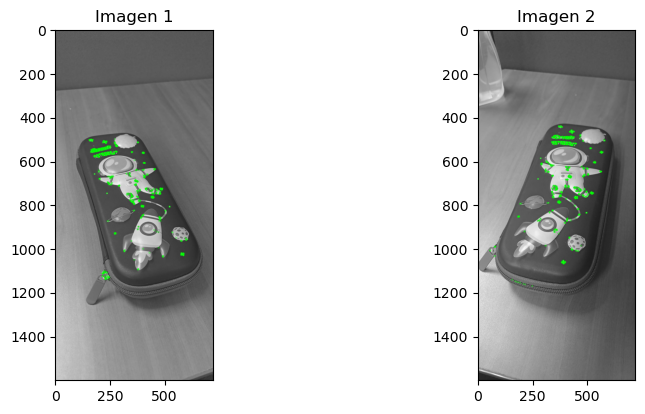

In [11]:
#  Leer imágenes
images = glob.glob('/Users/guillermo_sego/Desktop/Segundo Semestre/CVision/Tarea 3/Pencilcase/*.jpeg')

# Inicializamos la figura para graficar
plt.figure(figsize=(10, len(images) * 5))

for i, fname in enumerate(images):
    # Leer la imágen
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)

    # Inicializar ORB
    orb = cv2.ORB_create(nfeatures=1000)

    # Detectar puntos claves y descriptores
    puntosClave, descriptores = orb.detectAndCompute(img, None)

    # Dibujar puntos clave
    imagenPuntosClave = cv2.drawKeypoints(img, puntosClave, None, color=(0, 255, 0), flags=0)
    
    # Mostrar las imágenes
    plt.subplot(len(images), 2, i + 1)
    plt.imshow(imagenPuntosClave)
    plt.title(f'Imagen {i + 1}')

plt.show()

Ahora definimos la función del algoritmo normalizado de 8 puntos.

In [15]:
# Función que normaliza los puntos para que el centroide esté en el origen y el promedio de las distancias al origen sea sqrt(2).
def normalizarPuntos(puntos):
    # Cálculo del centroide
    centroid = np.mean(puntos, axis=0)
    puntos_norm = puntos - centroid

    # Escalamiento de las distancias
    distancias = np.linalg.norm(puntos_norm, axis=1)
    escala = np.sqrt(2) / np.mean(distancias)

    # Construcción de matriz de normalización
    matriz_norm = np.array([[escala, 0, -escala * centroid[0]],
                            [0, escala, -escala * centroid[1]],
                            [0, 0, 1]])
    puntos_norm = np.dot(matriz_norm, np.hstack((puntos, np.ones((puntos.shape[0], 1)))).T).T
    return puntos_norm, matriz_norm

In [16]:
def Norm8Points(xi, xip):
    # Normalizar los puntos
    xi_norm, T1 = normalizarPuntos(xi)
    xip_norm, T2 = normalizarPuntos(xip)
    
    # Construir la matriz A
    A = np.zeros((len(xi), 9))
    for i, (p1, p2) in enumerate(zip(xi_norm, xip_norm)):
        x1, y1, _ = p1
        x2, y2, _ = p2
        A[i] = [x2*x1, x2*y1, x2, y2*x1, y2*y1, y2, x1, y1, 1]
    
    # Descomposición en valores singulares de A y extracción de F
    U, D, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3, 3)
    
    # Forzar a que F sea de rango 2
    Uf, Df, Vtf = np.linalg.svd(F)
    Df[2] = 0  # Poner a cero el valor singular más pequeño
    F = Uf @ np.diag(Df) @ Vtf
    
    # Desnormalizar la matriz fundamental
    F = T2.T @ F @ T1
    return F
    

Una vez con el código del algoritmo de 8 puntos implementado, podemos implementar la función que hace una estimación de la matriz fundamental de dos imágenes agregando RANSAC para estimar la mejor matriz para nuestras imágenes. Para agregar el RANSAC se implementa una función adicional que realiza un procedimiento de RANSAC básico. En la función de RANSAC se utiliza la matriz implementada del algoritmo de 8 puntos, por lo que esta función es suficiente para calcular la matriz fundamental a partir de dos conjuntos de puntos. 

In [18]:
def RANSAC(xi, xip, iteraciones=1000, umbral=0.01):
    max_inliers = 0
    F_final = None
    inliers_final = []

    for _ in range(iteraciones):
        # Seleccionar aleatoriamente 8 puntos
        idx = np.random.choice(len(xi), 8, replace=False)
        xi_sample = xi[idx]
        xip_sample = xip[idx]
        
        # Calcular la matriz fundamental usando los puntos seleccionados
        F = Norm8Points(xi_sample, xip_sample)  # Asumiendo que Norm8Points es equivalente
        
        # Calcular la cantidad de inliers
        inliers_idx = []
        for i in range(len(xi)):
            p1 = np.append(xi[i], 1)
            p2 = np.append(xip[i], 1)
            if abs(p2.T @ F @ p1) < umbral:
                inliers_idx.append(i)
        
        # Actualizar la mejor matriz fundamental si se encuentra una con más inliers
        if len(inliers_idx) > max_inliers:
            max_inliers = len(inliers_idx)
            F_final = F
            inliers_final = inliers_idx
    
    return F_final, inliers_final

Para graficar las líneas epipolares se necesita una función que dibuje las líneas epipolares y además marque los puntos correspondientes en cada imagen.

In [41]:
def dibujar_lineas_epipolares(img1, img2, lines, pts1, pts2):
    r, c = img1.shape # Dimensiones de la primer imágen

    # Convertir a escala de grises
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # Generar un color aleatorio para cada conjunto de lineas y puntos
        color = tuple(np.random.randint(0, 255, 3).tolist())

        # Calcula las lineas
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])

        # Dibujar las lineas
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)

        # Marcar los puntos con círculos
        img1 = cv2.circle(img1, (int(pt1[0]), int(pt1[1])), 5, color, -1)
        img2 = cv2.circle(img2, (int(pt2[0]), int(pt2[1])), 5, color, -1)
        
    return img1, img2

In [42]:
def FundamentalMatrix(img1_path, img2_path):
    # Leer imágenes
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Inicializar ORB y encontrar puntos clave y descriptores
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Emparejar los descriptores con el matcher de fuerza bruta
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Extraer las coordenadas de los puntos emparejados
    puntos1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    puntos2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Calcular la matriz fundamental usando RANSAC y obtener índices de inliers
    F, inliers_idx = RANSAC(puntos1, puntos2)

    print("Matriz Fundamental Estimada:\n", F)

    # Seleccionar solo los puntos inliers
    pts1_inliers = puntos1[inliers_idx]
    pts2_inliers = puntos2[inliers_idx]

    # Calcular y dibujar líneas epipolares para los puntos inliers
    lines1 = cv2.computeCorrespondEpilines(pts2_inliers.reshape(-1, 1, 2), 2, F)
    lines1 = lines1.reshape(-1, 3)
    img5, img6 = dibujar_lineas_epipolares(img1, img2, lines1, pts1_inliers, pts2_inliers)

    lines2 = cv2.computeCorrespondEpilines(pts1_inliers.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)
    img3, img4 = dibujar_lineas_epipolares(img2, img1, lines2, pts2_inliers, pts1_inliers)

    # Mostrar las imágenes con líneas epipolares
    plt.subplot(121), plt.imshow(img5)
    plt.subplot(122), plt.imshow(img3)
    plt.show()


Vamos a probar la función con 10 diferentes imágenes tomadas por un smartphone de diferentes objetos, desde diferentes perspectivas como si se tratase de dos cámaras. 

Matriz Fundamental Estimada:
 [[ 5.43373345e-06 -2.18121518e-05  9.83125077e-03]
 [ 1.93227114e-05  1.57276960e-05 -2.07888170e-02]
 [-1.39640046e-02  3.92401003e-04  7.99703548e+00]]


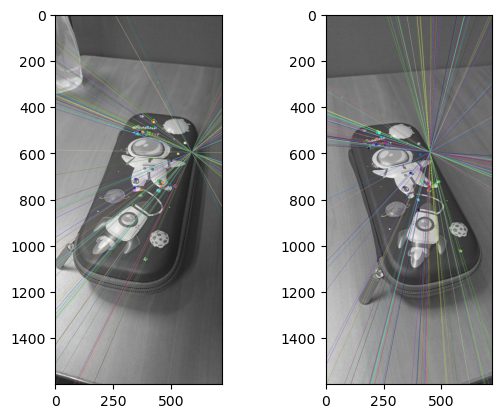

In [65]:
imagesPencilcase = sorted(glob.glob('/Users/guillermo_sego/Desktop/Segundo Semestre/CVision/Tarea 3/Pencilcase/*.jpeg'))

# Probamos la función
FundamentalMatrix(imagesPencilcase[0], imagesPencilcase[1])

Matriz Fundamental Estimada:
 [[-5.67804820e-06  3.85737232e-07  5.52173297e-03]
 [-3.36643976e-07 -3.80621942e-08  3.81003308e-04]
 [ 5.92748872e-03 -2.79013327e-04 -5.87314962e+00]]


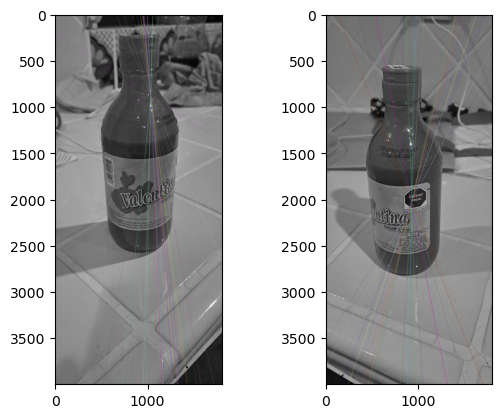

Matriz Fundamental Estimada:
 [[-2.73289503e-06  2.63525033e-07  1.00721664e-03]
 [-1.83725867e-06  2.05963464e-07  6.19653449e-04]
 [ 6.72219107e-03 -7.50232890e-04 -2.27388165e+00]]


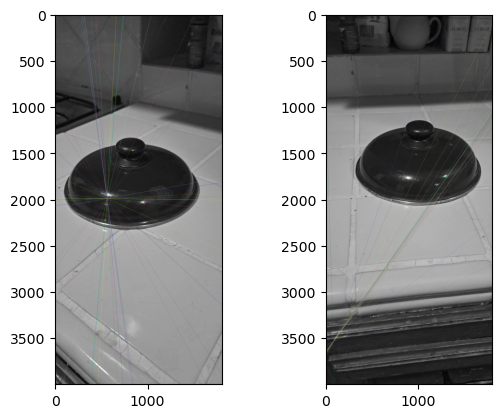

Matriz Fundamental Estimada:
 [[ 2.68324843e-07  1.19007149e-06 -2.18329434e-03]
 [-4.21937242e-08  3.58554990e-07 -4.58661734e-03]
 [ 6.41733627e-04  1.93379246e-03  3.02140873e+00]]


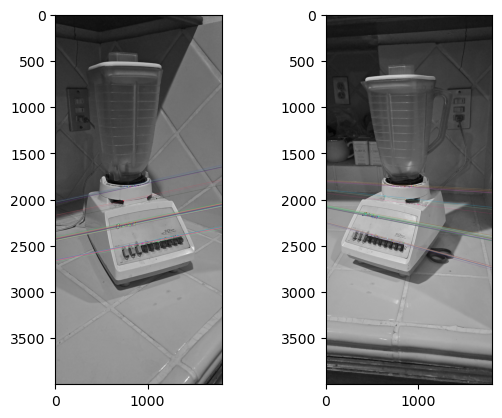

Matriz Fundamental Estimada:
 [[-3.06460378e-06 -3.61600166e-06  9.25609182e-03]
 [ 1.72846596e-06  6.84629566e-06 -1.35832733e-02]
 [-8.90444738e-04 -9.79664750e-03  1.79053674e+01]]


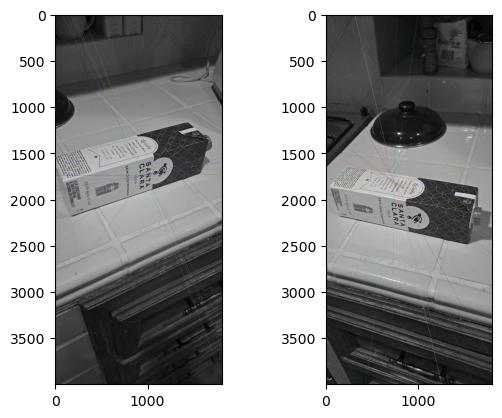

Matriz Fundamental Estimada:
 [[-5.02291745e-06  7.08221569e-07  3.19574320e-03]
 [-2.71025642e-08  5.49555490e-09  1.54266779e-05]
 [ 3.36771303e-03 -4.79108105e-04 -2.13801753e+00]]


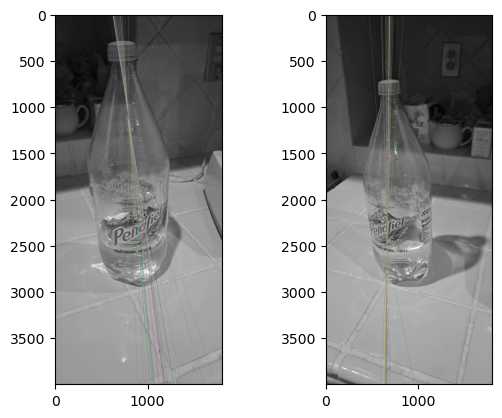

In [66]:
# Leer imágenes
images = sorted(glob.glob('/Users/guillermo_sego/Desktop/Segundo Semestre/CVision/Tarea 3/Kitchen/*.jpg'))

# Calcular las matrices y las líneas epipolares
for i in range(0, len(images) - 1, 2):  
    if i + 1 < len(images):  # Verifica que haya una imagen siguiente para formar un par
        FundamentalMatrix(images[i], images[i + 1])

Le cuesta a la función cuando tenemos superficies sin tantos relieves sobre los cuales se puedan encontrar los puntos. 

# Ejercicio 2

Use one pair among the undistorted images from the following [dataset](https://github.com/iSarmad/SFM-MATLAB/tree/master/Data): (where you also have the intrinsic parameters of the camera in K.txt). 

- Estimate the essential matrix (you can use FindFundamentalMat from openCV).
- Deduce (up to a scale) the 3D displacement between cameras. 
- Triangulate the matched key points into 3D points, as described in lecture 10. 
- Plot the obtained 3D points.

--- 

La Matriz Esencial (usualmente denotada por E): Es un caso especial de la matriz fundamental cuando las cámaras están calibradas (es decir, se conocen los parámetros intrínsecos de la cámara). La matriz esencial encapsula la rotación y la traslación entre dos vistas de una cámara y se utiliza para estimar la pose relativa de las cámaras [1].

Utilizamos un par de imágenes del dataset proporcionado, además podemos utilizar la función `FindFundamentalMat`de OpenCV. 

In [67]:
# Para la gráfica en 3D
from mpl_toolkits.mplot3d import Axes3D 

In [75]:
# Cargar imágenes y parámetros intrínsecos de la cámara
img1 = cv2.imread('/Users/guillermo_sego/Desktop/Segundo Semestre/CVision/Tarea 3/Data/0000.JPG', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/Users/guillermo_sego/Desktop/Segundo Semestre/CVision/Tarea 3/Data/0005.JPG', cv2.IMREAD_GRAYSCALE)
K = np.loadtxt('/Users/guillermo_sego/Desktop/Segundo Semestre/CVision/Tarea 3/Data/K.txt')

# Inicializar ORB y encontrar puntos clave y descriptores
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Emparejar los descriptores con el matcher de fuerza bruta
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Extraer las coordenadas de los puntos emparejados
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

# Estimar la matriz esencial
E, mask = cv2.findEssentialMat(pts1, pts2, K)

print("Matriz Esencial:\n", E)

# Recuperar rotación y traslación
_, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)

# Preparar las matrices de proyección para la triangulación
P1 = np.hstack((K, np.zeros((3, 1))))
P2 = K @ np.hstack((R, t))

# Triangulación de puntos en 3D
points_4D_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
points_3D = points_4D_hom / points_4D_hom[3]  # Convertir a coordenadas euclidianas

Matriz Esencial:
 [[-0.02654806  0.22887888  0.0837012 ]
 [ 0.16851692  0.05747094 -0.6804423 ]
 [-0.02282371  0.66635237  0.02558886]]


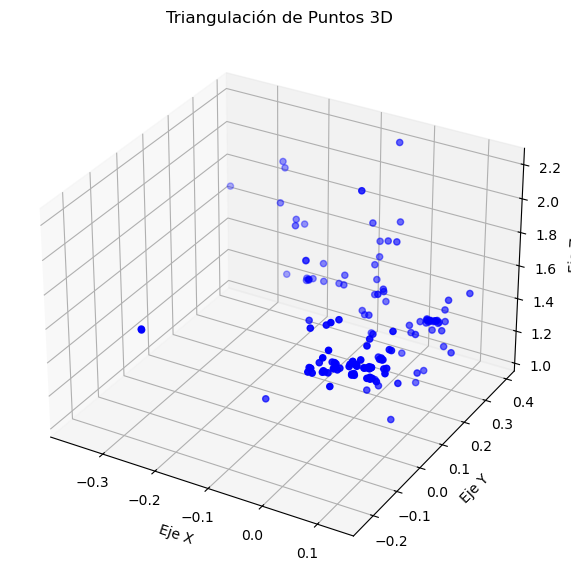

In [73]:
# Visualización de los puntos 3D
# Convertir puntos 4D homogéneos a 3D
points_3D = points_4D_hom[:3, :] / points_4D_hom[3, :]

# Figura
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Títulos y etiquetas
ax.set_title('Triangulación de Puntos 3D')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')

# Plot de los puntos 3D
scatter = ax.scatter(points_3D[0], points_3D[1], points_3D[2], c='blue', marker='o')

plt.show()

# Ejercicio 3

Show that in the general case of two cameras, two points **$p$**, **$p^T$** that are the projections of a common 3D point satisfy:

$$
p' \propto K' R K^{-1} p + \frac{1}{Z} K' t
$$

where $Z$ is a scalar.
- How can the rst term be interpreted?
- How can you interpret Z?
- Assuming that you can identify points at the innity, how could you estimate R?
- Assuming that R has been estimated, how could you use the formula above to estimate t?

---

Este problema describe la relación entre las proyecciones de un punto 3D en dos cámaras diferentes y cómo estos puntos proyectados se relacionan con los parámetros intrínsecos y extrínsecos de las cámaras.

La ecuación:

$$
p' \propto K' R K^{-1} p + \frac{1}{Z} K' t
$$

es una forma de describir cómo un punto **$p$** en la imagen de la primera cámara se relaciona con su correspondencia **$p'$** en la imagen de la segunda cámara, dados los parámetros de ambas cámaras y la posición del punto en el espacio 3D.

**Término ($K' R K^{-1} p$)**.
- Este término describe la rotación y re-proyección del punto **$p$** de la primera cámara a la segunda cámara.
- **$K^{-1} p$** transforma el punto **$p$** de coordenadas de imagen a coordenadas del mundo.
- **$R$** rota este punto al sistema de coordenadas de la segunda cámara.
- **$K'$** re-proyecta el punto rotado de vuelta al plano de imagen de la segunda cámara.

**Término ($\frac{1}{Z} K' t$)**.
- Este término representa el efecto de la traslación entre las cámaras en la proyección del punto.
- **$t$** es el vector de traslación desde la primera cámara a la segunda.
- **$Z$** es la profundidad del punto en el espacio 3D con respecto a la primera cámara.
- **$K' t$** proyecta el vector de traslación al plano de imagen de la segunda cámara, y **$\frac{1}{Z}$** escala este efecto basándose en la profundidad del punto, lo que significa que cuanto más lejos esté el punto, menor será el efecto de la traslación en su proyección.

**Interpretación de $Z$**. Este valor representa la profundidad del punto 3D en relación con el sistema de coordenadas de la primera cámara. Indica qué tan "lejos" está el punto en la dirección perpendicular al plano de imagen de la cámara.

**Estimar de $R$**. Para estimar R, si se puede identificar puntos en el infinito, el término de traslación **$\frac{1}{Z} K' t$** se vuelve insignificante. Entonces, en este caso, la relación se simplifica a **$p' \propto K' R K^{-1} p$**. Además, si se tiene suficientes correspondencias de puntos en el infinito, se puede estimar **$R$** resolviendo este sistema de ecuaciones.

**Estimación de $t$**. Una vez estimada **$R$**, se puede reorganizar la ecuación original para resolver **$t$** usando puntos que no están en el infinito. Esto se puede realizar aislando el término **$\frac{1}{Z} K' t$** y utilizando múltiples correspondencias de puntos para formar un sistema de ecuaciones que permita estimar **$t$**. 

## Referencias

[1] Hartley, Richard, and Andrew Zisserman. Multiple view geometry in computer vision. Cambridge university press, 2003.

[2] Tyagi, Deepanshu. “Introduction to ORB (Oriented FAST and Rotated BRIEF).” Medium. Medium, 2019. Online. Internet. 24 Feb. 2024. [Available](medium.com/@deepanshut041/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf)
